In [117]:
import numpy as np #导入 NumPy 库
import pandas as pd #导入 Pandas 库
import matplotlib.pyplot as plt #导入 Matplotlib 库中的 pyplot 模块
import requests #导入 Requests 库


sequences = []
with open('./GSM7566824_WT_ChIP-nexus_CTCF_peaks_with_labels_50.fa', 'r') as file:
    sequence = ''
    for line in file:
        if line.startswith('>'):
            continue  # 跳过以'>'开头的行
        sequence = line.strip().upper()  # 去除两端空白并转换为大写
        sequences.append(sequence)
sequences = list(filter(None, sequences)) # 过滤掉空序列,最外层还是要套一层list，否则不是list类型，是map类型


# 先看看数据集长什么样
pd.DataFrame(sequences, index=np.arange(1, len(sequences)+1),
             columns=['Sequences']).head()

,Sequences
1,GCCCCCTGCTGGCGCCGGGGCACTGCAGGGCCCTCTTGCTTACTGT...
2,CAGGAGGGCTGAGGACCTCTGGTGGCGGCCCAGGGCTTCCAGCATG...
3,ACAGTCTCAGTTGCACACACGAGCCAGCAGAGGGGTTTTGTGCCAC...
4,GGCTTCCCCAGCCCTCCCTTCTGCCCTCCTCAGGCCAGCACTTTTC...
5,TTCTCCTCAGTTTCTCTGTGTGGCACCAGGTGGCAGCAGAGGTCAG...


In [118]:
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder #导入OneHotEncoder即可，用于将序列编码为one-hot 编码；无需导入LabelEncoder，用于将序列编码为整数


# 创建一个 OneHotEncoder 实例，用于将整数编码转换为 one-hot 编码
one_hot_encoder = OneHotEncoder(categories=[['A', 'C', 'G', 'T']])
input_features = [] #初始化一个空列表，用于存储每个序列的 one-hot 编码

for sequence in sequences:
    # 将序列中的每个碱基转换为列向量
    sequence_array = np.array(list(sequence)).reshape(-1, 1)

    # 将字符序列转换为 one-hot 编码
    one_hot_encoded = one_hot_encoder.fit_transform(sequence_array)

    # 将 one-hot 编码转换为数组并添加到 input_features 列表中
    input_features.append(one_hot_encoded.toarray())

# # 中间查看检验一下
# for i, feature in enumerate(input_features):
# # enumerate返回index、value的元组
#     print(f"Array {i} shape: {feature.shape},has value {feature}")

np.set_printoptions(threshold=40) #设置打印选项，限制输出的元素数量,表示在打印时如果数组超过40个元素，则只打印开头和结尾的部分
input_features = np.stack(input_features) #将 input_features 列表转换为 numpy 数组
print(input_features)

print("Example sequence\n-----------------------")  #打印示例序列的标题
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:]) #打印第一个 DNA 序列的前 10 个和后 10 个碱基
print('One hot encoding of Sequence #1:\n',input_features[0]) #打印第一个 DNA 序列的 one-hot 编码

[[[0. 0. 1. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  ...
  [0. 0. 0. 1.]
  [1. 0. 0. 0.]
  [0. 0. 1. 0.]]

 [[0. 1. 0. 0.]
  [1. 0. 0. 0.]
  [0. 0. 1. 0.]
  ...
  [0. 0. 1. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]]

 [[1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [1. 0. 0. 0.]
  ...
  [0. 0. 0. 1.]
  [0. 1. 0. 0.]
  [0. 0. 0. 1.]]

 ...

 [[0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 1. 0. 0.]
  ...
  [0. 0. 1. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]]

 [[0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  ...
  [1. 0. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]]

 [[0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 1.]
  ...
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]]]
Example sequence
-----------------------
DNA Sequence #1:
 GCCCCCTGCT ... TACTGTATAG
One hot encoding of Sequence #1:
 [[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]


In [119]:
# 提取最后一列并保存到 labels.txt 文件中
# cut -f 4 GSM7566824_WT_ChIP-nexus_CTCF_peaks_with_labels_50.bed > labels.txt

# 读取 labels.txt 文件
with open('./labels.txt', 'r') as file:
    labels = file.read().splitlines()
#读取文件的所有内容，并按行分割成一个列表。splitlines() 方法会移除每行末尾的换行符

# 移除空行
labels = list(filter(None, labels))

# 创建一个 OneHotEncoder 实例
# one_hot_encoder = OneHotEncoder(categories='auto')
one_hot_encoder = OneHotEncoder(categories=[['0', '1']])
# 之所以这里用auto，而前面要指定ATCG的category但不使用auto，是因为前面是针对单个序列的，而这里是对整个数据集的，所以需要自动识别category
# 是因为前面是对于单个sequence，但是整体识别中有多个sequence，所以需要对于整体的数据集进行one-hot编码，所以需要指定ATGC的category,但是这里的category是auto，是因为这里没有整体的循环，相当于只有一个sequence要处理，所以不需要指定category，识别出来就是0-3
# 当然也可以更改数据类型one_hot_encoder = OneHotEncoder(categories=[['0', '1']])

# 将标签转换为 NumPy 数组并进行独热编码
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n', labels)
print('One-hot encoded labels:\n', input_labels)

Labels:
 [['1']
 ['0']
 ['1']
 ...
 ['1']
 ['1']
 ['1']]
One-hot encoded labels:
 [[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [120]:
from sklearn.model_selection import train_test_split #将数据集拆分为训练集和测试集

train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size=0.25, random_state=2025, stratify=input_labels)
#（features，labels）实际上就是（x，y）

print ("x_train shape: ", train_features.shape)
#print(train_features)
print ("y_train shape: ", train_labels.shape)
#print(train_labels)
print("x_test shape: ", test_features.shape)
#print(test_features)
print ("y_test shape: ", test_labels.shape)


x_train shape:  (39925, 50, 4)
y_train shape:  (39925, 2)
x_test shape:  (13309, 50, 4)
y_test shape:  (13309, 2)


In [121]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, BatchNormalization, Input, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2


model = Sequential()

model.add(Input(shape=(train_features.shape[1], 4)))
model.add(Conv1D(filters=16, kernel_size=20, kernel_regularizer=l2(0.01), activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(filters=32, kernel_size=3, kernel_regularizer=l2(0.01), activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(filters=64, kernel_size=3, kernel_regularizer=l2(0.01), activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# 全连接层
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))  # 增加神经元数量
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))  # 增加神经元数量
model.add(Dropout(0.5))


model.add(Dense(2, activation='softmax'))
# model.add(Dense(1, activation='sigmoid'))

# model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), metrics=['binary_accuracy']) #learning_rate=0.001，初始学习率，因为后期的loss下降的太慢
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['binary_accuracy']) #learning_rate=0.001，初始学习率，因为后期的loss下降的太慢

model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_42 (Conv1D)              │ (None, 31, 16)         │         1,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_42 (MaxPooling1D) │ (None, 15, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 15, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 15, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_43 (Conv1D)              │ (None, 13, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_43 (MaxPooling1D) │ (None, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 6, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ (None, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_44 (Conv1D)              │ (None, 4, 64)          │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_44 (MaxPooling1D) │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 2, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,698 (295.70 KB)

 Trainable params: 75,474 (294.82 KB)

 Non-trainable params: 224 (896.00 B)

In [122]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# ReduceLROnPlateau 回调函数，用于在验证损失不再改善时减少学习率
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.000001)

# ModelCheckpoint 回调函数，用于在验证损失不再改善时保存最好的模型
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')

class_weight = {0: 3.234, 1: 1}  # 根据类别比例调整权重
# total = len(input_labels)
# pos = sum(input_labels[:,1].flatten()).item()
# neg = total - pos
# weight_for_0 = (1 / neg) * (total / 2.0)
# weight_for_1 = (1 / pos) * (total / 2.0)
# class_weight = {0: weight_for_0, 1: weight_for_1}
# print(class_weight)

In [123]:
# history = model.fit(train_features, train_labels, epochs=100, batch_size=32, verbose=1, validation_split=0.25, class_weight=class_weight, callbacks=[reduce_lr, checkpoint])
history = model.fit(train_features, train_labels, epochs=100, batch_size=3200, verbose=1, validation_split=0.25, class_weight=class_weight, callbacks=[reduce_lr, checkpoint])
# history = model.fit(train_features, train_labels[:, 1].reshape(-1, 1), epochs=100, batch_size=3200, verbose=1, validation_split=0.25, class_weight=class_weight, callbacks=[reduce_lr, checkpoint])

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - binary_accuracy: 0.5191 - loss: 5.3062 - val_binary_accuracy: 0.2643 - val_loss: 4.2279 - learning_rate: 0.0010
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - binary_accuracy: 0.5264 - loss: 4.5578 - val_binary_accuracy: 0.3221 - val_loss: 3.6716 - learning_rate: 0.0010
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - binary_accuracy: 0.5065 - loss: 3.9470 - val_binary_accuracy: 0.3911 - val_loss: 3.1713 - learning_rate: 0.0010
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - binary_accuracy: 0.5083 - loss: 3.4492 - val_binary_accuracy: 0.4034 - val_loss: 2.7355 - learning_rate: 0.0010
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - binary_accuracy: 0.5168 - loss: 3.0120 - val_binary_accuracy: 0.3261 - val_loss: 2.3647 - learning_rate: 0.0010
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - binary_accuracy: 0.5305 - loss: 2.6538 - val_binary_accuracy: 0.2368 - val_loss: 2.0557 - learning_rate: 0.0010
Epoc

In [124]:
predicted_train_labels = model.predict(np.stack(train_features))
predicted_test_labels = model.predict(np.stack(test_features))

1248/1248 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
416/416 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


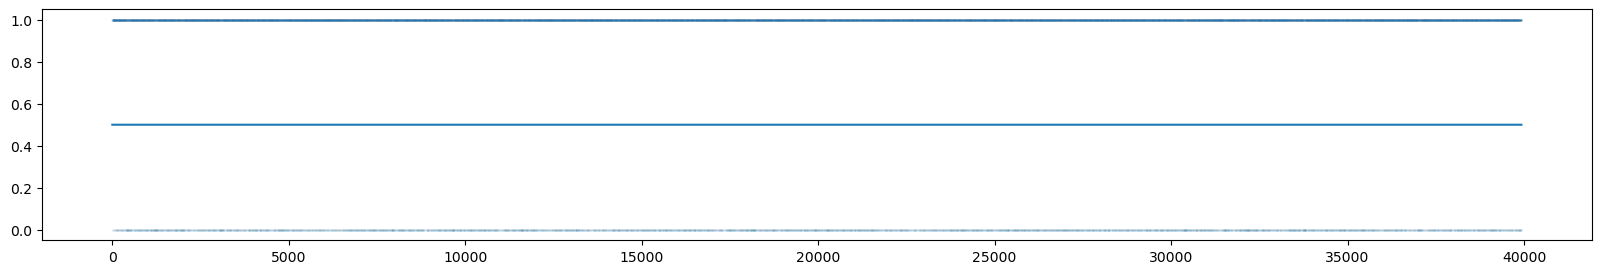

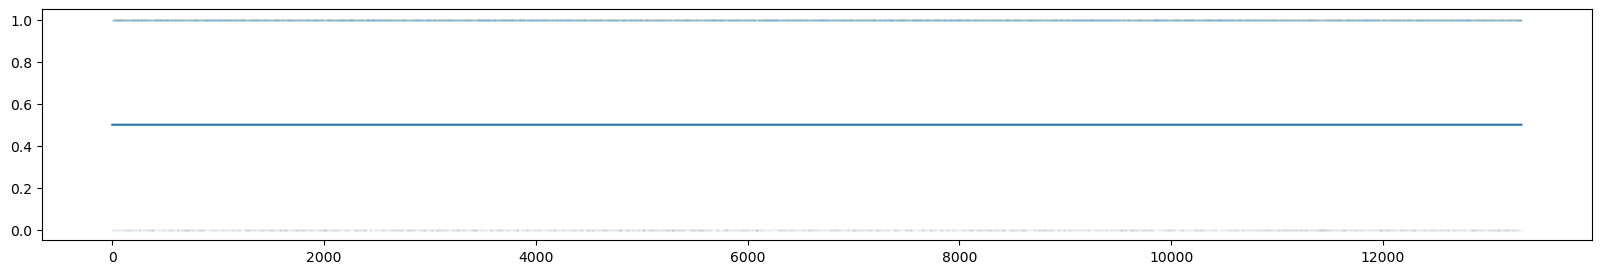

In [113]:
idx = predicted_train_labels.flatten().argsort()
plt.figure(figsize=(20, 3))
plt.plot(predicted_train_labels.flatten()[idx])
plt.scatter(np.arange(len(idx)), train_labels[:,1].flatten()[idx], alpha=0.02, s=1)

idx = predicted_test_labels.flatten().argsort()
plt.figure(figsize=(20, 3))
plt.plot(predicted_test_labels.flatten()[idx])
plt.scatter(np.arange(len(idx)), test_labels[:,1].flatten()[idx], alpha=0.02, s=1)

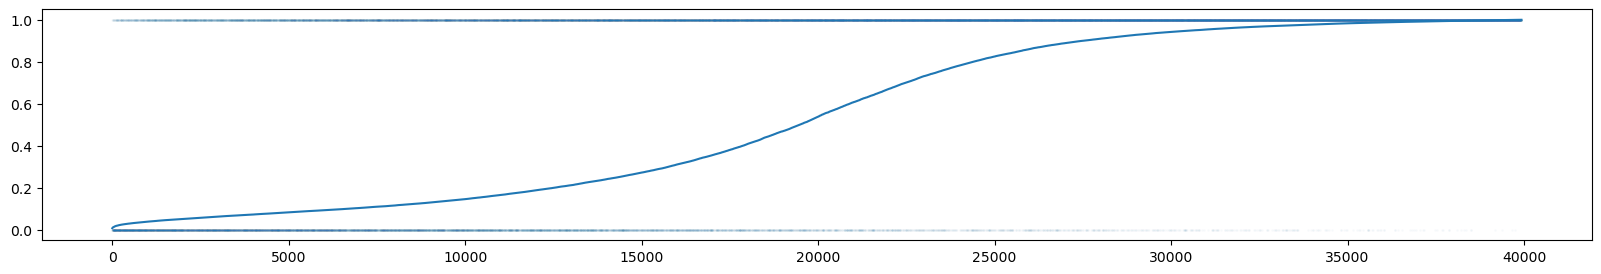

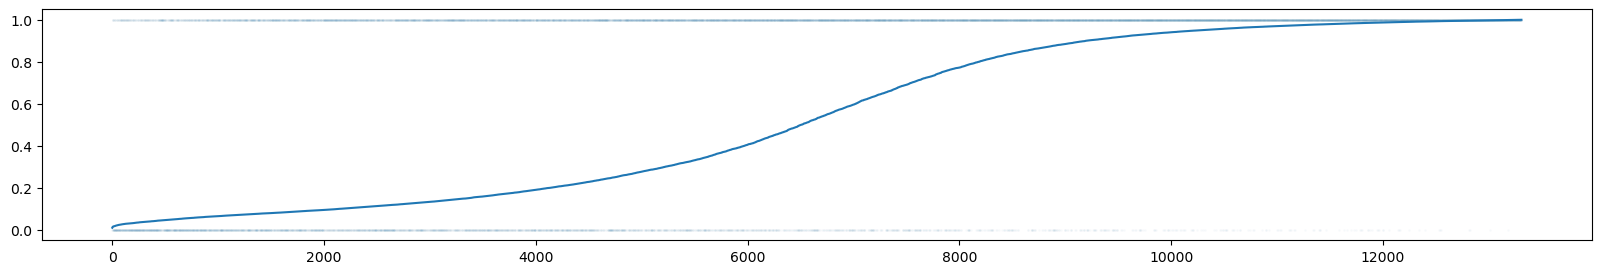

In [125]:
idx = predicted_train_labels[:,1].flatten().argsort()
plt.figure(figsize=(20, 3))
plt.plot(predicted_train_labels[:,1].flatten()[idx])
plt.scatter(np.arange(len(idx)), train_labels[:,1].flatten()[idx], alpha=0.02, s=1)

idx = predicted_test_labels[:,1].flatten().argsort()
plt.figure(figsize=(20, 3))
plt.plot(predicted_test_labels[:,1].flatten()[idx])
plt.scatter(np.arange(len(idx)), test_labels[:,1].flatten()[idx], alpha=0.02, s=1)

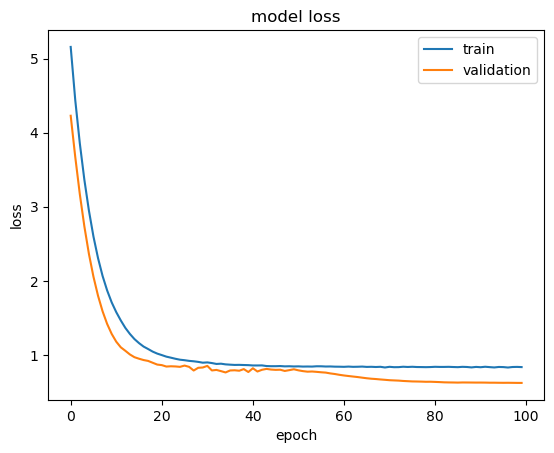

In [126]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

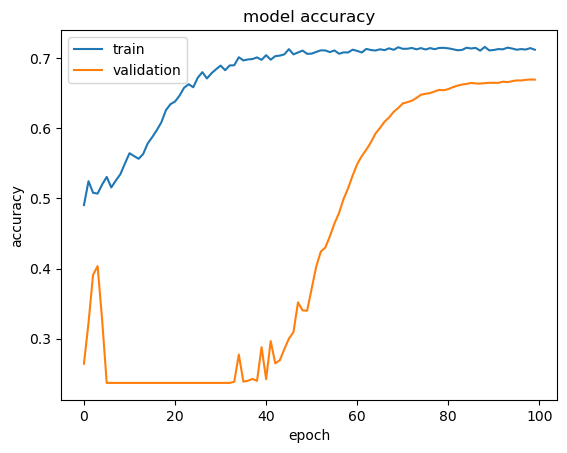

In [127]:
plt.figure()
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

416/416 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Confusion matrix:
 [[2708  436]
 [4111 6054]]


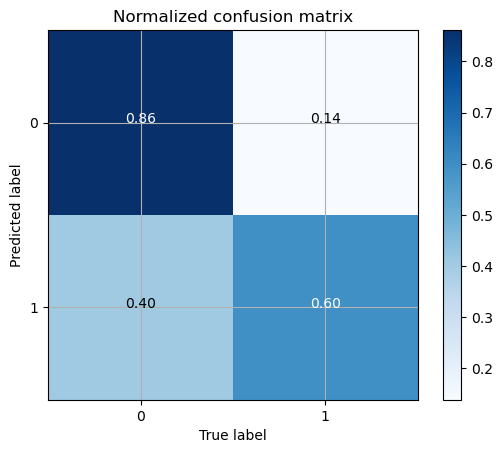

In [27]:
from sklearn.metrics import confusion_matrix
import itertools

predicted_labels = model.predict(np.stack(test_features))
cm = confusion_matrix(np.argmax(test_labels, axis=1),
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')

In [ ]:
import tensorflow.keras.backend as K

def compute_salient_bases(model, x):
  input_tensors = [model.input]
  gradients = model.optimizer.get_gradients(model.output[0][1], model.input)
  compute_gradients = K.function(inputs = input_tensors, outputs = gradients)

  x_value = np.expand_dims(x, axis=0)
  gradients = compute_gradients([x_value])[0][0]
  sal = np.clip(np.sum(np.multiply(gradients,x), axis=1),a_min=0, a_max=None)
  return sal

In [ ]:
sequence_index = 1999  # You can change this to compute the gradient for a different example. But if so, change the coloring below as well.
sal = compute_salient_bases(model, input_features[sequence_index])

plt.figure(figsize=[16,5])
barlist = plt.bar(np.arange(len(sal)), sal)
[barlist[i].set_color('g') for i in range(5,17)]  # Change the coloring here if you change the sequence index.
plt.xlabel('Bases')
plt.ylabel('Magnitude of saliency values')
plt.xticks(np.arange(len(sal)), list(sequences[sequence_index]));
plt.title('Saliency map for bases in one of the positive sequences'
          ' (green indicates the actual bases in motif)');

In [ ]:
from tensorflow.keras.models import load_model

# 加载最好的模型
best_model = load_model('best_model.keras')

# 在测试集上评估模型
test_loss, test_accuracy = best_model.evaluate(test_features, test_labels)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

# 使用最好的模型进行预测
# predictions = best_model.predict(new_data)

416/416 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.7655 - loss: 0.6924
Test loss: 0.692446231842041
Test accuracy: 0.7637688517570496


In [ ]:
!pip install logomaker

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import logomaker
import matplotlib.pyplot as plt
import pandas as pd

# 加载最好的模型
best_model = load_model('best_model.keras')

# 打印模型的层结构以确认卷积层的索引
for i, layer in enumerate(best_model.layers):
    print(i, layer.name, layer.output)

# 第一层卷积层的索引是0
conv_layer_index = 0

# 获取第一层卷积层的卷积核权重
weights = best_model.layers[conv_layer_index].get_weights()[0]

# 可视化卷积核中的 ACGT motif logo
fig, ax = plt.subplots(4, 4, figsize=(15, 15))
for i in range(4):
    for j in range(4):
        if i * 4 + j < weights.shape[-1]:
            w = weights[:, :, i * 4 + j]
            df = pd.DataFrame(w, columns=["A", "C", "G", "T"])
            logomaker.Logo(df, ax=ax[i, j])
            ax[i, j].set_title(f"Kernel {i*4+j} weights")
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# 加载最好的模型
best_model = load_model('best_model.keras')


# 打印模型的层结构以确认卷积层的索引
for i, layer in enumerate(best_model.layers):
    print(i, layer.name, layer.output)
# 假设第一层卷积层的索引是1
conv_layer_index = 0

# 可视化第一层卷积层的卷积核
weights = best_model.layers[conv_layer_index].get_weights()[0]
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    if i < weights.shape[-1]:
        ax.imshow(weights[:, :, i], cmap='viridis')
        ax.set_title(f'Filter {i}')
plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 加载最好的模型
best_model = load_model('best_model.keras')

# 打印模型的层结构以确认卷积层的索引
for i, layer in enumerate(best_model.layers):
    print(i, layer.name, layer.output)

# 获取第一个卷积层的权重
conv_layer_index = 0
weights = best_model.layers[conv_layer_index].get_weights()[0]

# 计算卷积核的重要性（这里使用权重的绝对值和作为重要性指标）
kernel_importance = np.sum(np.abs(weights), axis=(0, 1))

# 可视化卷积核的重要性
plt.figure(figsize=(10, 6))
plt.bar(range(len(kernel_importance)), kernel_importance)
plt.xlabel('Kernel index')
plt.ylabel('Importance')
plt.title('Importance of Each Kernel in the First Convolutional Layer')
plt.show()

# 可视化卷积核的权重
fig, axes = plt.subplots(4, 4, figsize=(15, 15))
for i in range(4):
    for j in range(4):
        if i * 4 + j < weights.shape[-1]:
            w = weights[:, :, i * 4 + j]
            df = pd.DataFrame(w, columns=["A", "C", "G", "T"])
            logomaker.Logo(df, ax=axes[i, j])
            axes[i, j].set_title(f"Kernel {i*4+j} weights")
plt.tight_layout()
plt.show()


0 conv1d <KerasTensor shape=(None, 31, 16), dtype=float32, sparse=False, name=keras_tensor_856>
1 max_pooling1d <KerasTensor shape=(None, 15, 16), dtype=float32, sparse=False, name=keras_tensor_858>
2 batch_normalization <KerasTensor shape=(None, 15, 16), dtype=float32, sparse=False, name=keras_tensor_861>
3 dropout <KerasTensor shape=(None, 15, 16), dtype=float32, sparse=False, name=keras_tensor_865>
4 conv1d_1 <KerasTensor shape=(None, 13, 32), dtype=float32, sparse=False, name=keras_tensor_870>
5 max_pooling1d_1 <KerasTensor shape=(None, 6, 32), dtype=float32, sparse=False, name=keras_tensor_876>
6 batch_normalization_1 <KerasTensor shape=(None, 6, 32), dtype=float32, sparse=False, name=keras_tensor_883>
7 dropout_1 <KerasTensor shape=(None, 6, 32), dtype=float32, sparse=False, name=keras_tensor_891>
8 conv1d_2 <KerasTensor shape=(None, 4, 64), dtype=float32, sparse=False, name=keras_tensor_900>
9 max_pooling1d_2 <KerasTensor shape=(None, 2, 64), dtype=float32, sparse=False, name=ke

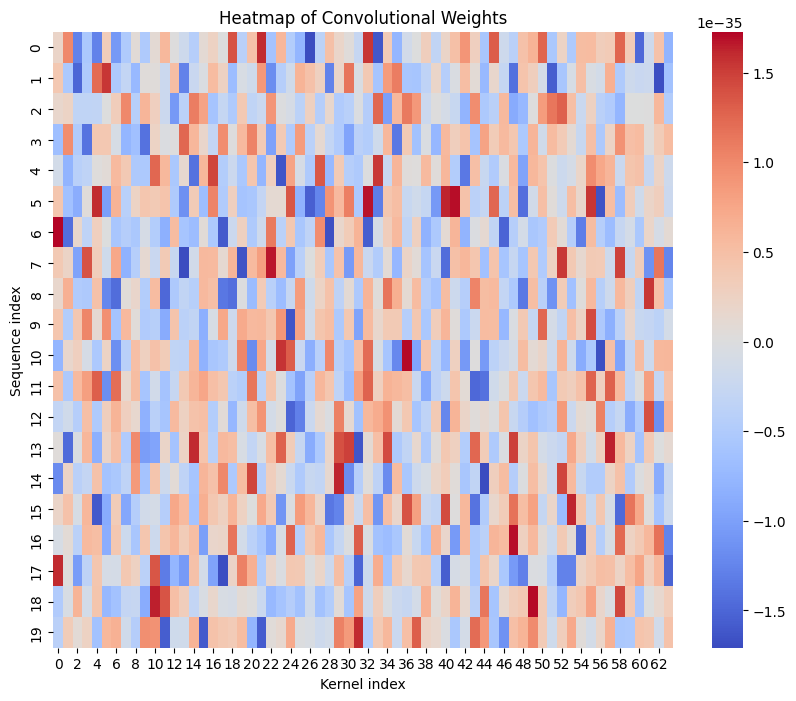

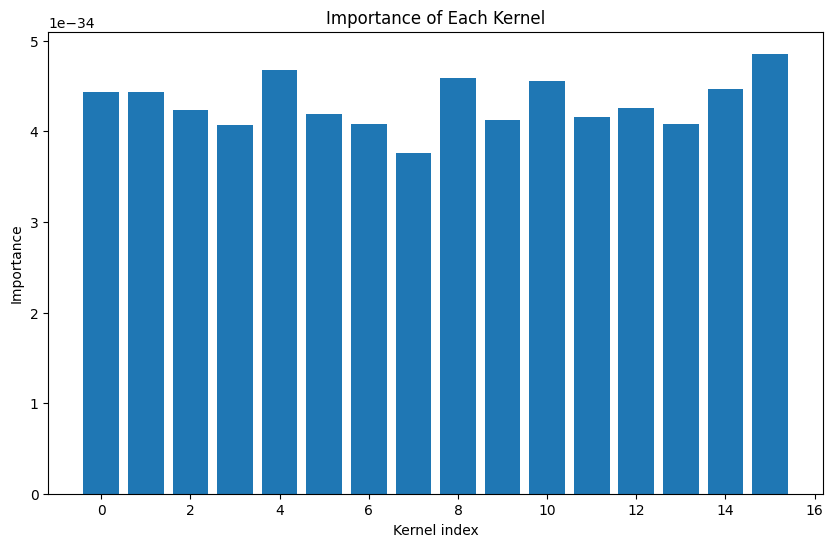

In [ ]:
#下面的是原来的代码
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 加载最好的模型
best_model = load_model('best_model.keras')

# 打印模型的层结构以确认卷积层的索引
for i, layer in enumerate(best_model.layers):
    print(i, layer.name, layer.output)

# 获取第一个卷积层的权重
conv_layer_index = 0
weights = best_model.layers[conv_layer_index].get_weights()[0]

# 计算卷积核的重要性（这里使用权重的绝对值和作为重要性指标）
kernel_importance = np.sum(np.abs(weights), axis=(0, 1))

# 可视化卷积核的权重
plt.figure(figsize=(10, 8))
sns.heatmap(weights.reshape(weights.shape[0], -1), cmap='coolwarm')
plt.xlabel('Kernel index')
plt.ylabel('Sequence index')
plt.title('Heatmap of Convolutional Weights')
plt.show()

# 可视化卷积核的重要性
plt.figure(figsize=(10, 6))
plt.bar(range(len(kernel_importance)), kernel_importance)
plt.xlabel('Kernel index')
plt.ylabel('Importance')
plt.title('Importance of Each Kernel')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# 加载最好的模型
best_model = load_model('best_model.keras')

# 打印模型的层结构以确认卷积层的索引
for i, layer in enumerate(best_model.layers):
    print(i, layer.name, layer.output)

# 对模型进行一次前向传播，以确保模型的输入和输出被定义
_ = best_model.predict(train_features[:1])

# 第一个卷积层的索引是0
conv_layer_index = 0

# 创建中间模型，输入与原始模型相同，但输出是第一个卷积层的输出
intermediate_model = tf.keras.Model(inputs=best_model.input, outputs=best_model.layers[conv_layer_index].output)

# 使用中间模型进行预测，得到特征图
intermediate_output = intermediate_model.predict(train_features[:1])

# 可视化第一个卷积层的特征图
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    if i < intermediate_output.shape[-1]:
        ax.imshow(intermediate_output[0, :, i], cmap='viridis')
        ax.set_title(f'Feature map {i}')
plt.tight_layout()
plt.show()